In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.40.0.4-py2.py3-none-any.whl size=177697886 sha256=8a0aa0551104e6f249a1d7e013f706629175e09b40f91cf867acf5ad07f714a5
  Stored in directory: /root/.cache/pip/wheels/43/f2/b0/5bb4d702a0467e82d77c45088db3eef25114c26b0eec8e7f6a
Successfully built h2o


In [ ]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.1 MB/s eta 0

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import time                                                       # for timers

# plotting functionality
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # necessary for custom legends

# display plots in notebook
%matplotlib inline

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Start global timer

In [ ]:
tic = time.time()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hmda_train_preprocessed.csv to hmda_train_preprocessed.csv


### Import data

In [ ]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles


In [ ]:
y_name = 'high_priced'

### Fit interpretable model

### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to debug

In [ ]:
# params dict for remediated models
rem_params = {'max_bins': 256,
              'max_interaction_bins': 64,
              'interactions': 15,
              'outer_bags': 12,
              'inner_bags': 0,
              'learning_rate': 0.01,
              'validation_size': 0.5,
              'min_samples_leaf': 2,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': 4,
              'random_state': 12345}

rem_x_names = ['debt_to_income_ratio_missing',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'income_std',
               'term_360',
               'property_value_std']

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7809.


#### Sensitivity Analysis: Stress Testing

#### Simulate recession conditions in validation data

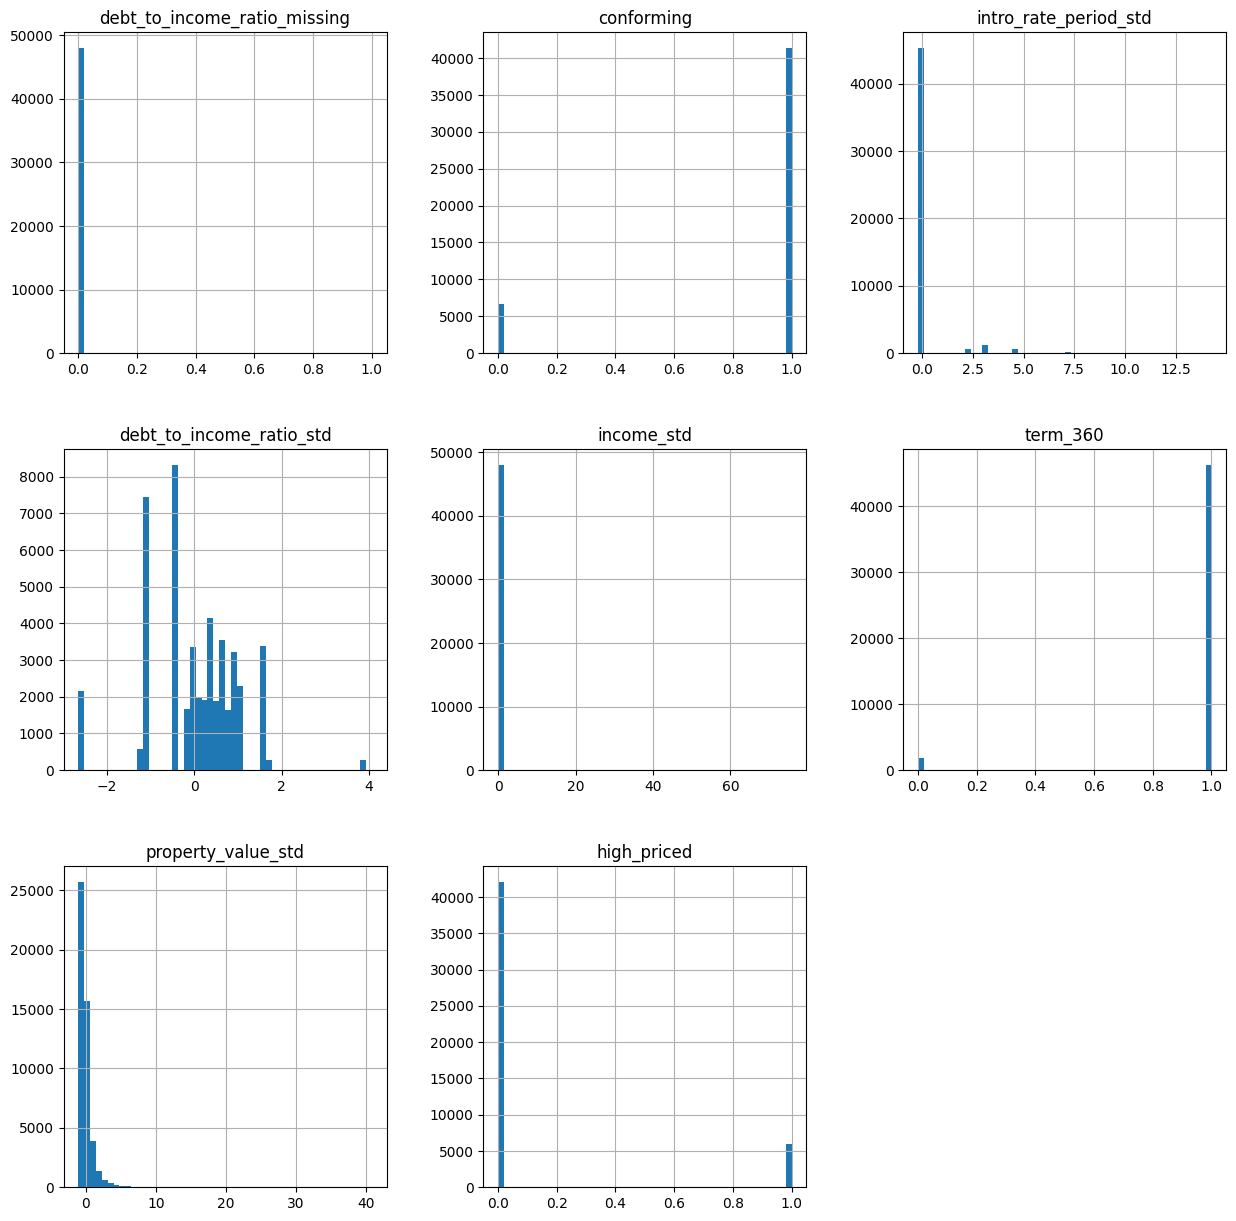

In [ ]:
np.random.seed(SEED) # set seed for this cell

rec_valid = valid.copy(deep=True) # deep copy of validation data

# use severity variable to control how many customers are affected
severity = 0.07
affected = np.random.rand(len(rec_valid)) < severity

# decrease debt_to_income_ratio_missing by 5%
rec_valid.loc[affected, 'debt_to_income_ratio_missing'] = rec_valid.loc[affected, 'debt_to_income_ratio_missing'] * 0.95

# less conforming loans
rec_valid.loc[affected, 'conforming'] = 0

# shorter intro rate periods
rec_valid.loc[affected, 'intro_rate_period_std'] = rec_valid.loc[affected, 'intro_rate_period_std'] * 0.95

# 5% higher debt-to-income ratios
rec_valid.loc[affected, 'debt_to_income_ratio_std'] = rec_valid.loc[affected, 'debt_to_income_ratio_std'] * 1.05

# lower income by 5%
rec_valid.loc[affected, 'income_std'] = rec_valid.loc[affected, 'income_std'] * 0.95

# more long loans
rec_valid.loc[affected, 'term_360'] = 1

# decrease property values by 5%
rec_valid.loc[affected, 'property_value_std'] = rec_valid.loc[affected, 'property_value_std'] * 0.95

# update target
rec_valid.loc[affected, y_name] = np.random.choice(2, len(rec_valid.loc[affected, y_name]))

# visualize results
_ = rec_valid[rem_x_names + [y_name]].hist(bins=50, figsize=(15, 15))

#### Find AUC for best model in simulated recession conditions

In [ ]:
rec_rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(rec_valid[rem_x_names], rec_valid[y_name])
rec_rem_auc = rec_rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rec_rem_auc)

Remediated EBM retrained with AUC: 0.6126.


#### Residual Analysis

#### Calculate predictions and logloss residuals for all data

In [ ]:
# shortcut names
yhat_name = 'phat'
r_name = 'r'

# calculate predictions
rem_ebm_phat = pd.DataFrame(rem_ebm.predict_proba(data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat = pd.concat([data.reset_index(drop=True), rem_ebm_phat], axis=1)

# calculate logloss residuals
rem_ebm_phat[r_name] = -rem_ebm_phat[y_name]*np.log(rem_ebm_phat[yhat_name]) -\
                       (1 - rem_ebm_phat[y_name])*np.log(1 - rem_ebm_phat[yhat_name])

### Plot residuals

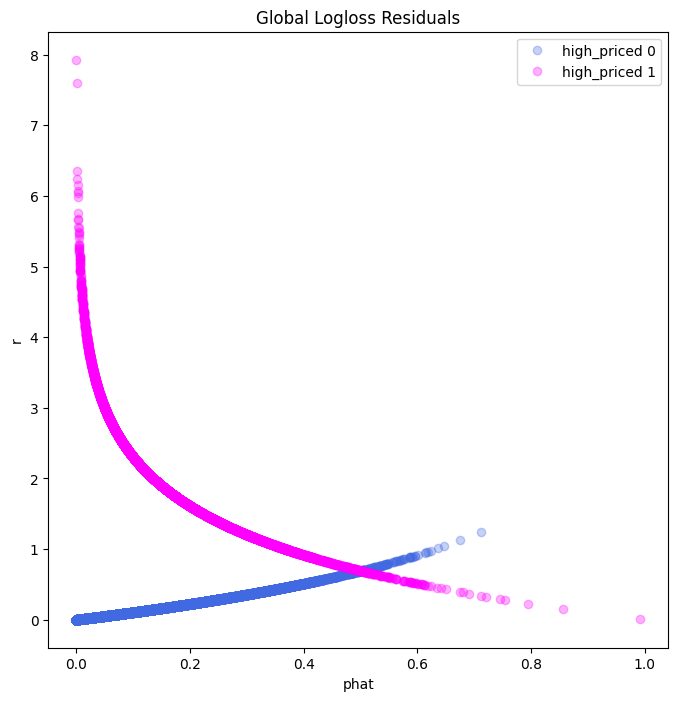

In [ ]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))

# plot groups with appropriate color
color_list = ['royalblue', 'magenta']
c_idx = 0
groups = rem_ebm_phat.groupby(y_name) # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.phat, group.r,
             label=' '.join([y_name, str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

# annotate plot
_ = plt.xlabel(yhat_name)
_ = plt.ylabel(r_name)
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

### Remediation: Remove Outliers

####  Find outliers

In [ ]:
rem_ebm_phat.sort_values(by='r', ascending=False).head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat,r
110822,110822,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.892723,-0.874794,0.244394,-0.215304,1.252485,-0.007738,-1.156406,1,0.000360,7.928492
82041,82041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,-0.954117,-2.973067,0.244394,-0.215304,0.697459,-0.052781,-0.425131,1,0.000502,7.596453
121375,121375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.851722,-0.249258,0.244394,-0.215304,7.758622,0.579546,-2.527547,1,0.001743,6.352380
128930,128930,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.130006,-3.257582,0.244394,-0.215304,0.759128,0.008893,0.854601,1,0.001951,6.239249
83113,83113,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.760806,-0.277030,0.244394,-0.215304,0.697459,0.017208,-0.059493,1,0.002129,6.152186


Remove worst outliers

In [ ]:
n_remove = 12
rem_data = data.copy(deep=True)
rem_data.drop(list(rem_ebm_phat.sort_values(by='r', ascending=False).head(n=n_remove).index), axis=0, inplace=True)

#### Remediation: Down-sample to Increase Signal from High-priced Loans

In [ ]:
inverse_proportion_remove = 12 # corresponds to keeping 1 - (1/inverse_proportion_remove) rows
rem_data.drop(list(rem_data[rem_data[y_name] == 0].index)[::inverse_proportion_remove], axis=0, inplace=True)

#### Retrain remediated EBM

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

# execute split
split = np.random.rand(len(rem_data)) < split_ratio
rem_train = rem_data[split]
rem_valid = rem_data[~split]

# summarize split
print('Remediated train data rows = %d, columns = %d' % (rem_train.shape[0], rem_train.shape[1]))
print('Remediated validation data rows = %d, columns = %d' % (rem_valid.shape[0], rem_valid.shape[1]))

# retrain
rem_ebm2 = ExplainableBoostingClassifier(**rem_params)
rem_ebm2.fit(rem_train[rem_x_names], rem_train[y_name])
rem_ebm_perf2 = ROC(rem_ebm2.predict_proba).explain_perf(rem_valid[rem_x_names], rem_valid[y_name])
rem_auc2 = rem_ebm_perf2._internal_obj['overall']['auc']
print('Remediated EBM under-sampled AUC: %.4f.' % rem_auc2)

Remediated train data rows = 103775, columns = 23
Remediated validation data rows = 44481, columns = 23
Remediated EBM under-sampled AUC: 0.7801.


#### Test remediated EBM on true validation data

In [ ]:
# calculate predictions
rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
rem_ebm_perf3 = ROC(rem_ebm2.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc3 = rem_ebm_perf3._internal_obj['overall']['auc']
print('Remediated EBM true AUC: %.4f.' % rem_auc3)

Remediated EBM true AUC: 0.7861.


Score validation data with model

In [ ]:
rem_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_phat2 = pd.concat([valid.reset_index(drop=True), rem_ebm_phat2], axis=1)
rem_ebm_phat2.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.119270
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.245534
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,1,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.034115
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,0.0,1,1,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.149874
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1,1,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.017857


Select percentiles from predictions

Calculate EBM contributions

In [ ]:
# start local timer
ebm_tic = time.time()

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = rem_ebm2.explain_local(valid[rem_x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 22), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

EBM contributions collected in 73.63 s.


In [ ]:
import pandas as pd
import numpy as np


# Create the 'global_fi' DataFrame with a single column 'EBM Importance'
global_fi = pd.DataFrame(columns=['EBM Importance'])

# Calculate the mean absolute EBM score for each feature
ebm_importance = np.abs(best_ebm_contribs_df).mean()

# Assign the EBM importance values to the 'EBM Importance' column in 'global_fi'
global_fi['EBM Importance'] = ebm_importance



HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Analyze feature importance


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

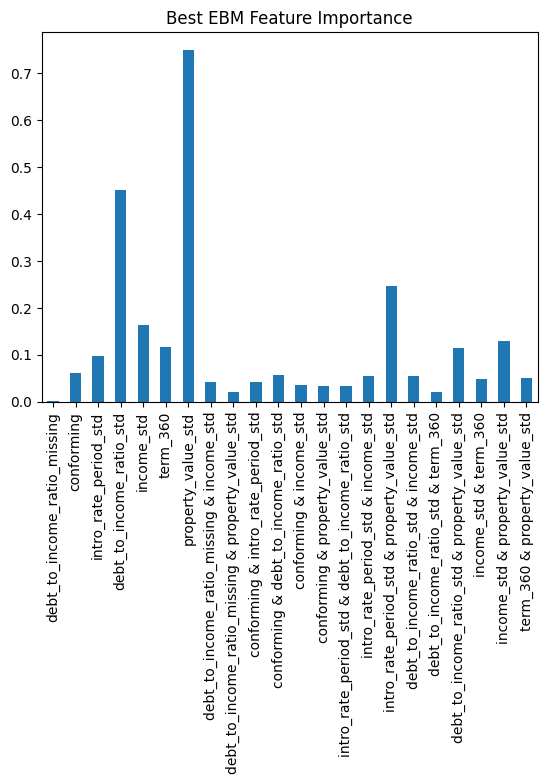

In [ ]:
_ = global_fi['EBM Importance'].plot(kind='bar', title='Best EBM Feature Importance')
plt.show()

Utility function for partial dependence

In [ ]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Calculate partial dependence

In [ ]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names to calculate par dep for EBM
for name in rem_x_names:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    pd_dict[name] = pd.DataFrame(columns=[name, 'ebm'])

    # calculate partial dependence using EBM model
    pd_result = par_dep(name, valid, rem_ebm, 'ebm')

    # store the results in the dictionary
    pd_dict[name][name] = pd_result[name]
    pd_dict[name]['ebm'] = pd_result['partial_dependence']

print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % pd_toc)


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for conforming ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for term_360 ...
Calculating partial dependence for property_value_std ...
Done.
Partial dependence calculated in 11.51 s.


Plot partial dependence for all features and models

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

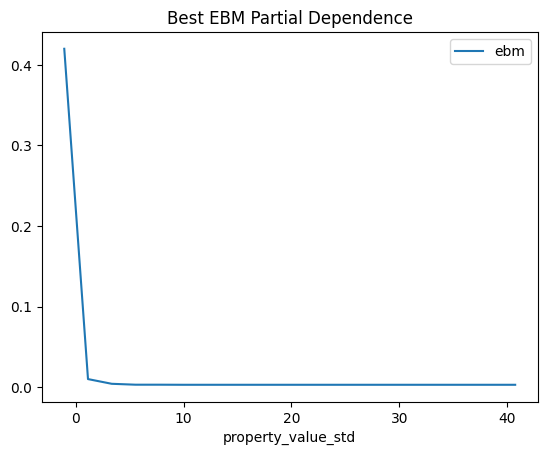

In [ ]:
pd_dict[name].plot(kind='line', x=name, y='ebm', title='Best EBM Partial Dependence')
ax.set_xlabel(feature)
plt.show()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

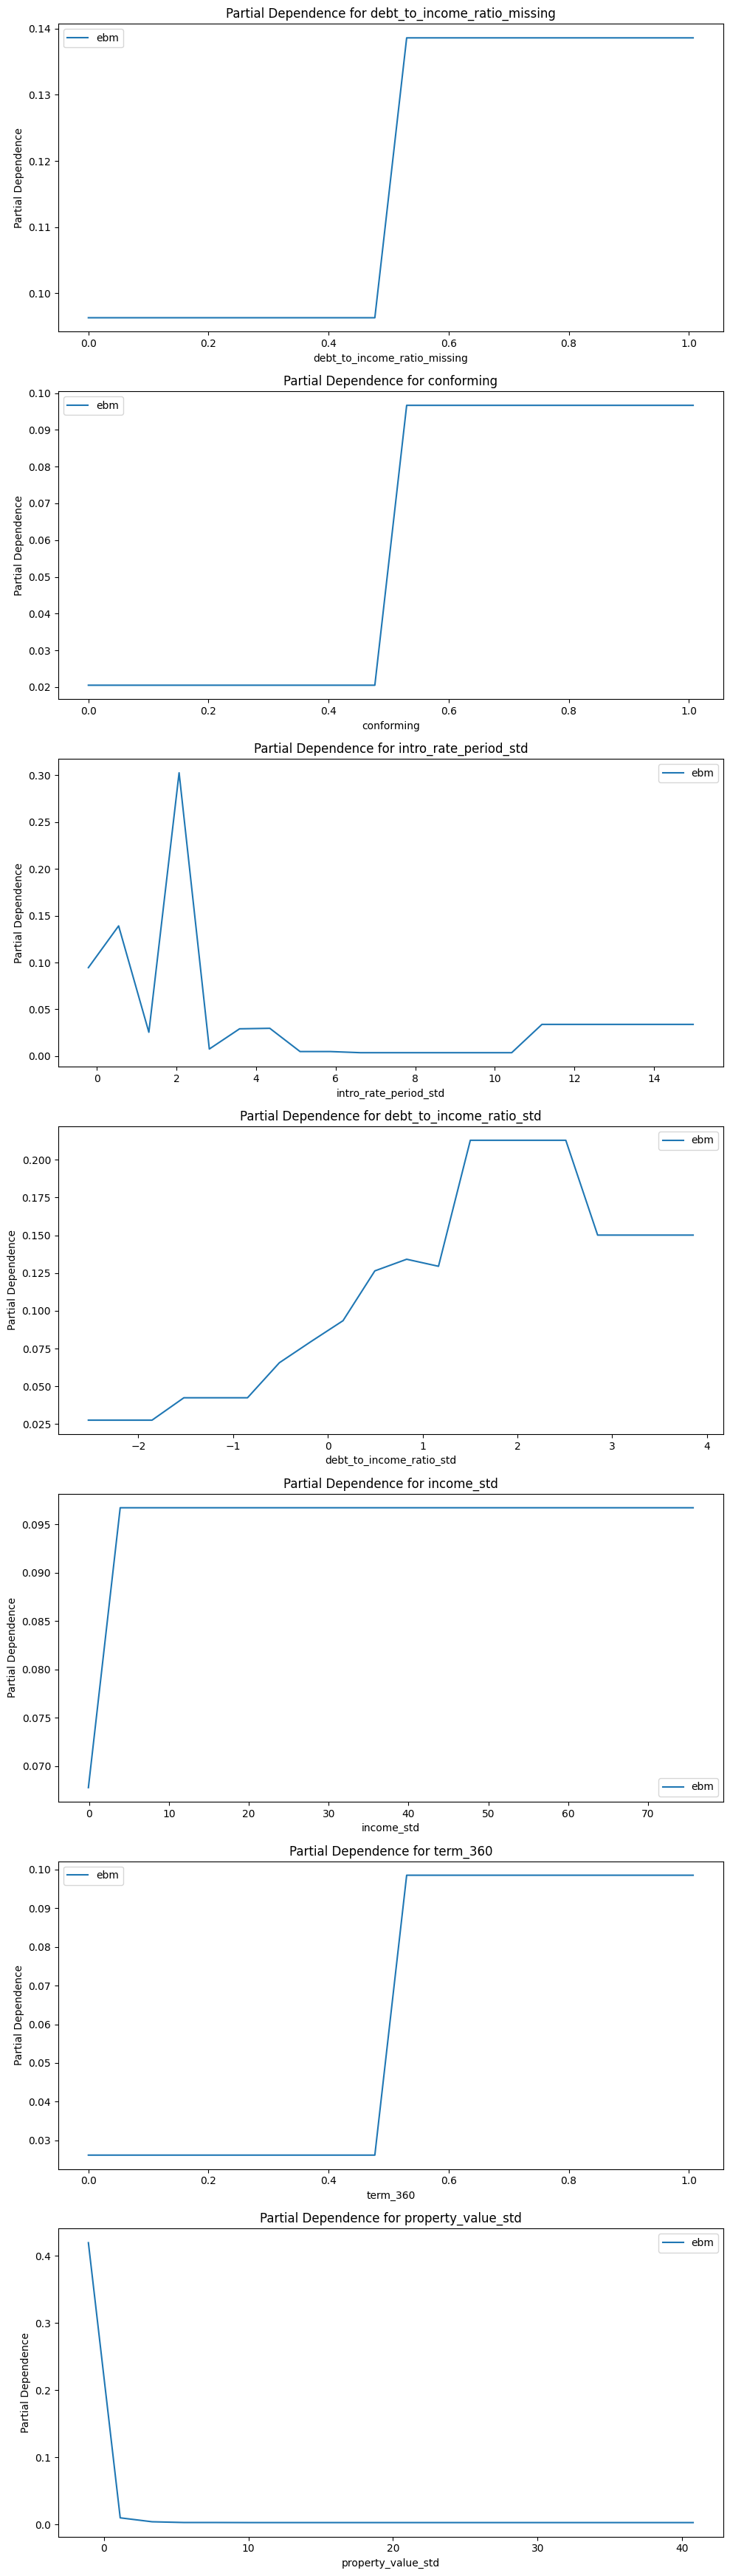

In [ ]:
ploimport matplotlib.pyplot as plt

# Create a figure and subplots
fig, axs = plt.subplots(len(pd_dict), 1, figsize=(10, len(pd_dict) * 5))

# Iterate over the features in pd_dict and plot the partial dependence
for i, feature in enumerate(pd_dict):
    ax = axs[i]
    pd_dict[feature].plot(kind='line', x=feature, y='ebm', ax=ax, title='Partial Dependence for {}'.format(feature))
    ax.set_xlabel(feature)
    ax.set_ylabel('Partial Dependence')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


FOR **PIML** test data

In [ ]:
rem_ebm_phat2.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.119270
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,1,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.245534
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,1,1,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.034115
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,1.0,0.0,1,1,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.149874
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,1.0,1,1,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.017857


In [ ]:
!pip install piml #Install PiML

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
from piml import Experiment# Import and init PiML
exp = Experiment()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
import pandas as pd
import numpy as np
exp = Experiment(highcode_only=True)
exp.data_loader(data=rem_ebm_phat2, silent=True)# import data
exp.data_summary(feature_type={}, feature_exclude=[])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(48085, 24)')

Feature removal

In [ ]:
exp.data_summary(feature_exclude=['row_id	', 'black', 'asian', 'white	','amind','hipac'	'hispanic','non_hispanic','male','female','agegte62','agelt62'])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(48085, 24)')

PiML data summary

In [ ]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

PiML data preparation

In [ ]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

PiML self-explainable model training

In [ ]:
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

with new paramter run same model

PiML data preparation ane train EBM model

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

EBM training completed in 19.29 s.


,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.9056,0.8257,0.0091,0.4925,0.0178
Test,0.9027,0.8265,0.0159,0.7500,0.0311
Gap,-0.0029,0.0008,0.0068,0.2575,0.0132


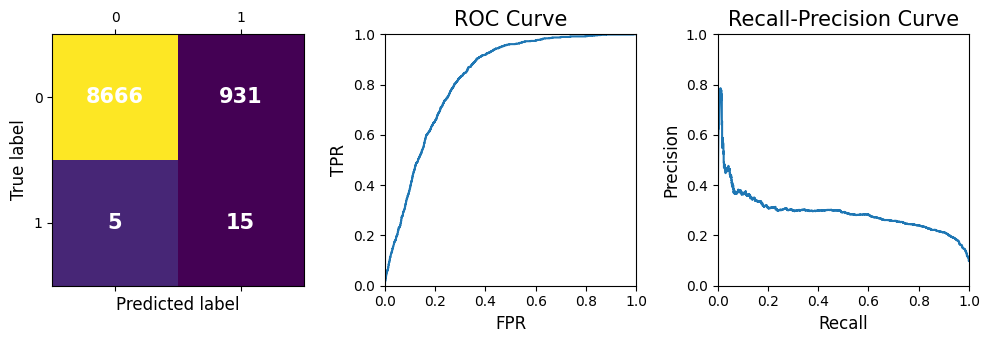

In [ ]:
from piml.models import ExplainableBoostingClassifier
import time
import pandas as pd
import numpy as np

exp.data_prepare(target="high_priced", task_type="classification", silent=True)

# Starting a local timer to measure the training time
ebm_tic = time.time()

ebm = ExplainableBoostingClassifier(interactions=10, outer_bags=3, max_interaction_bins=15)
exp.model_train(model=ebm, name='EBM')  # Training the EBM model

# End local timer
ebm_toc = time.time() - ebm_tic

print('EBM training completed in %.2f s.' % ebm_toc)  # Printing training time

exp.model_diagnose(model="EBM", show='accuracy_table')  # Test model performance using accuracy table
exp.model_diagnose(model="EBM", show='accuracy_plot', figsize=(10, 4))  # Test model performance using accuracy plot



 Global Importance feature  

Effect Importance

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

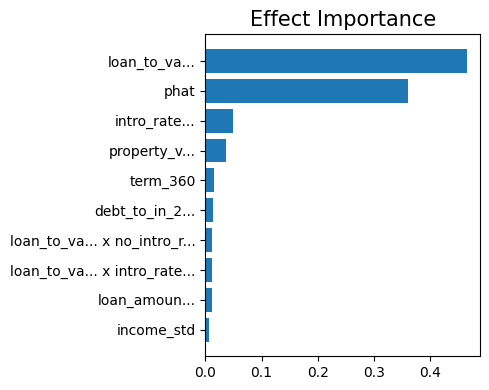

In [ ]:
exp.model_interpret(model="EBM", show="global_ei", figsize=(5, 4))

Feature Importance

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

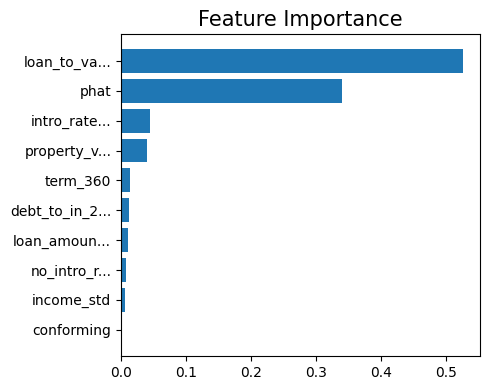

In [ ]:
exp.model_interpret(model="EBM", show="global_fi", figsize=(5, 4))

Partial Dependence Plot

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

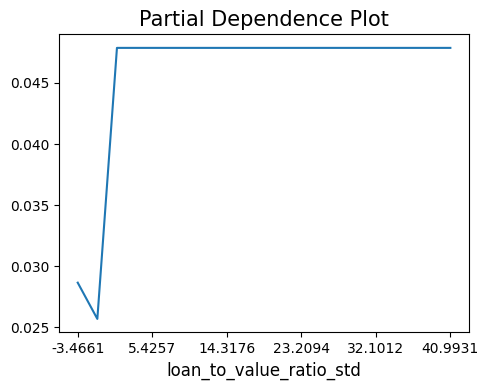

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="loan_to_value_ratio_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

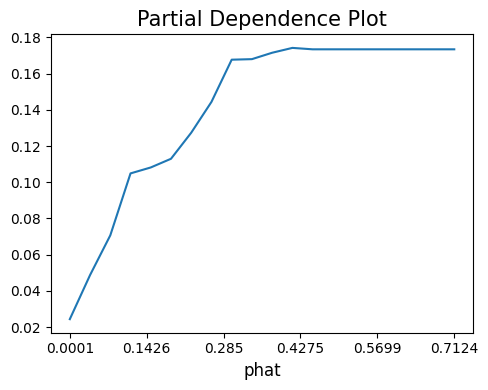

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="phat",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

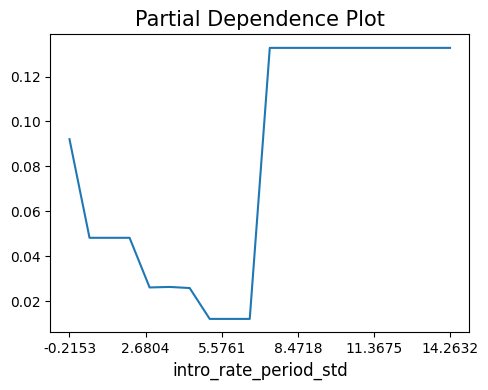

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="intro_rate_period_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

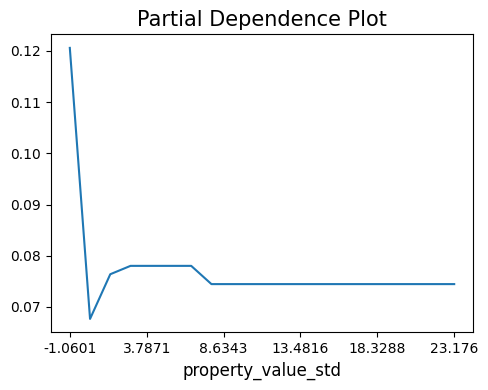

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="property_value_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

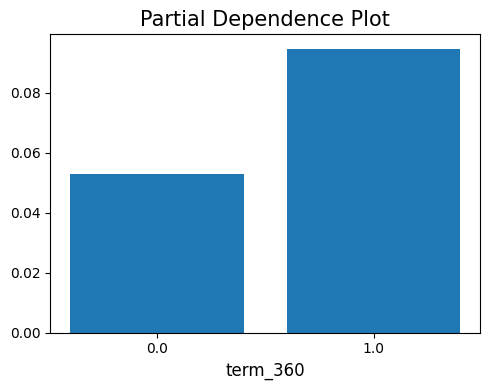

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="term_360",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

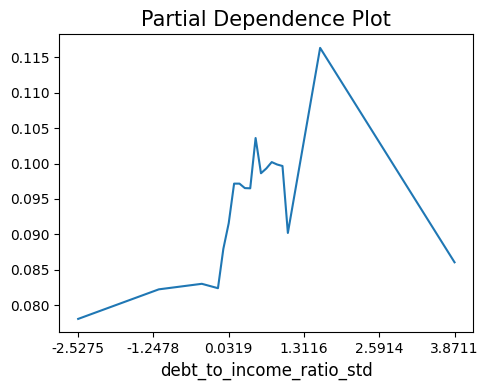

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="debt_to_income_ratio_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

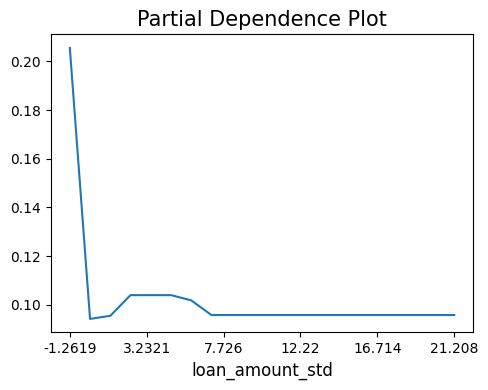

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="loan_amount_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

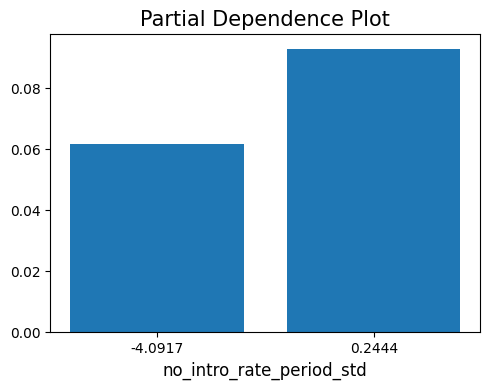

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="no_intro_rate_period_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

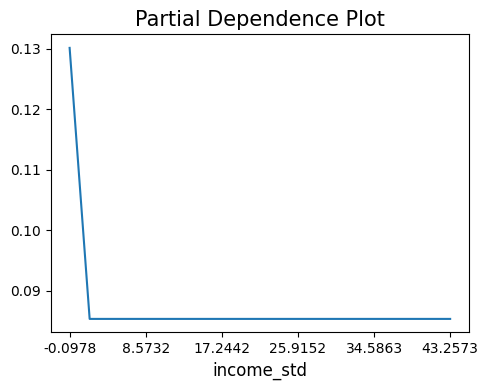

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="income_std",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

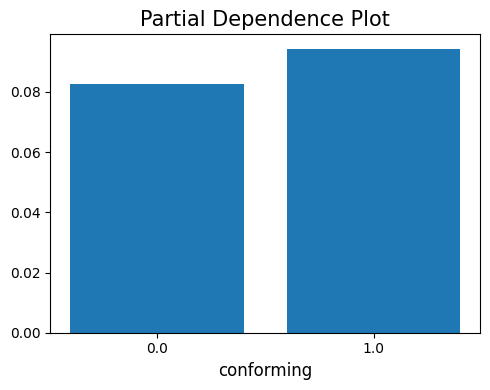

In [ ]:
exp.model_explain(model="EBM", show="pdp", uni_feature="conforming",
                  original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

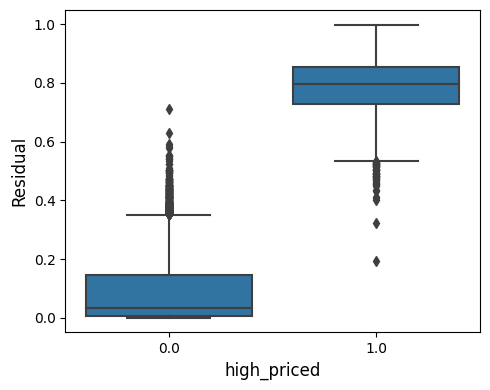

In [ ]:
exp.model_diagnose(model="EBM", show="accuracy_residual", target_feature="high_priced",
                   use_test=False, original_scale=True, figsize=(5, 4))

One-way WeakSpot Plot¶

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

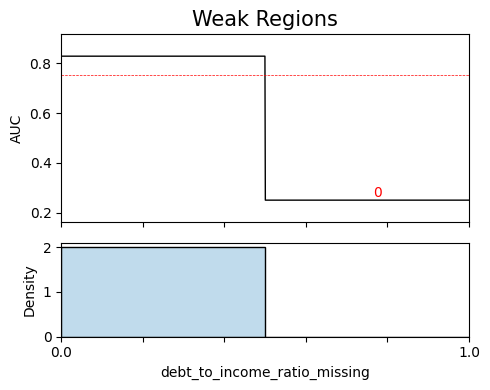

,[debt_to_income_ratio_missing,debt_to_income_ratio_missing),#Test,#Train,test_AUC,train_AUC,Gap
0,0.5,1.0,6,23,0.25,0.763158,-0.513158


In [ ]:
results = exp.model_diagnose(model="EBM", show="weakspot", slice_method="histogram",
                        slice_features=["debt_to_income_ratio_missing"], threshold=1.1, min_samples=100, metric="AUC",
                        use_test=True, return_data=True, original_scale=True, figsize=(5, 4))
results.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

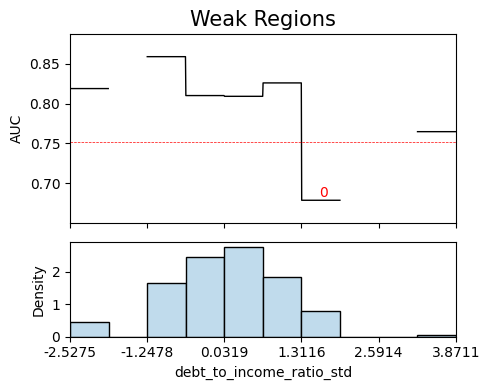

,[debt_to_income_ratio_std,debt_to_income_ratio_std),#Test,#Train,test_AUC,train_AUC,Gap
0,0.6,0.7,745,2906,0.678265,0.721299,-0.043035


In [ ]:
results = exp.model_diagnose(model="EBM", show="weakspot", slice_method="histogram",
                        slice_features=["debt_to_income_ratio_std"], threshold=1.1, min_samples=100, metric="AUC",
                        use_test=True, return_data=True, original_scale=True, figsize=(5, 4))
results.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

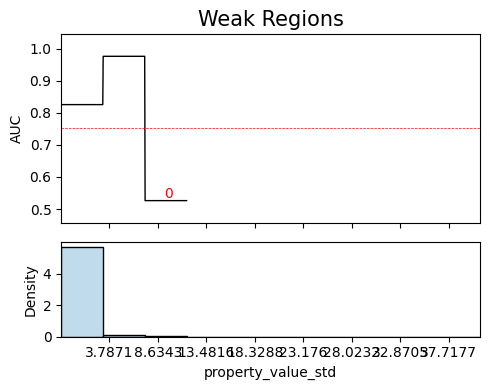

,[property_value_std,property_value_std),#Test,#Train,test_AUC,train_AUC,Gap
0,0.346819,0.519593,21,75,0.526316,NaN,NaN


In [ ]:
results = exp.model_diagnose(model="EBM", show="weakspot", slice_method="histogram",
                        slice_features=["property_value_std"], threshold=1.1, min_samples=100, metric="AUC",
                        use_test=True, return_data=True, original_scale=True, figsize=(5, 4))
results.data

One-way Overfit Plot¶

In [ ]:
results = exp.model_diagnose(model="EBM", show="overfit", slice_method="histogram",
                           slice_features=["property_value_std"], threshold=1.05, min_samples=100,
                           original_scale=True, return_data=True, figsize=(5, 4))

'No Overfit regions detected.'

Robustness on the whole test sample¶

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

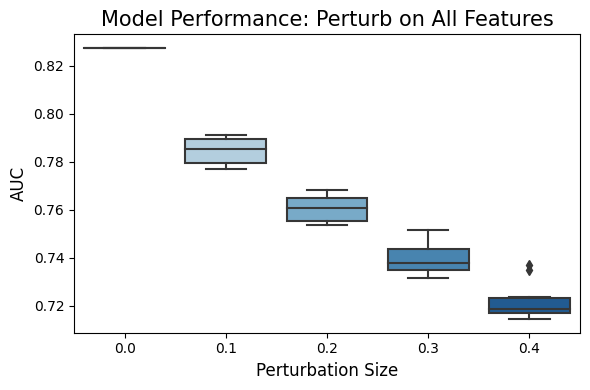

In [ ]:
exp.model_diagnose(model="EBM", show='robustness_perf', perturb_features=None,
                  perturb_method="raw", metric="AUC", perturb_size=0.1, figsize=(6, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

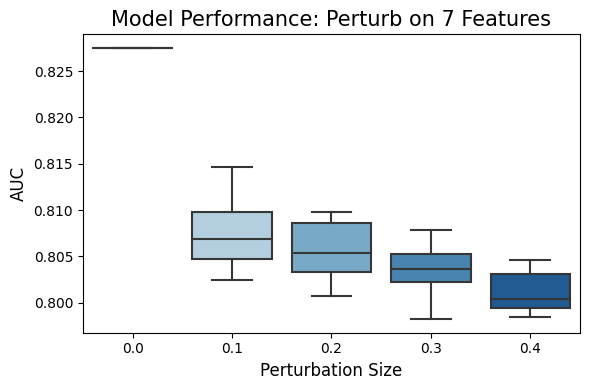

In [ ]:
exp.model_diagnose(model="EBM", show="robustness_perf", perturb_features=['debt_to_income_ratio_missing',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'income_std',
               'term_360',
               'property_value_std'],
                  perturb_method='raw', metric="AUC", perturb_size=0.1,  figsize=(6, 4))

Robustness test on worst alpha-percent samples

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

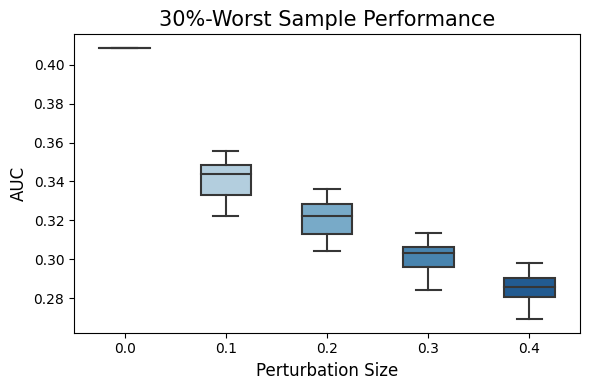

In [ ]:
exp.model_diagnose(model="EBM", show="robustness_perf_worst", alpha=0.3, figsize=(6, 4))

Resilience Performance

worst-sample

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

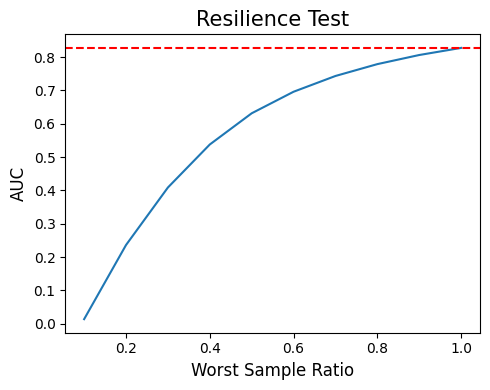

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_perf", resilience_method="worst-sample",
                   metric="AUC", figsize=(5, 4))

hard-sample


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

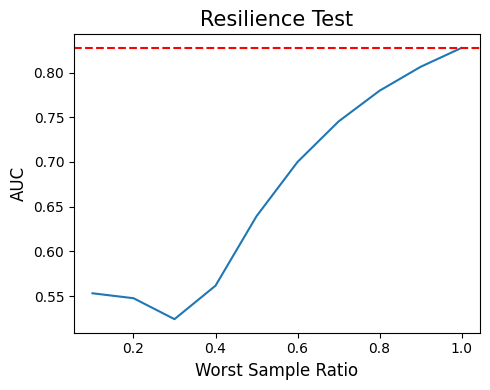

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_perf", resilience_method="hard-sample",
                   metric="AUC", figsize=(5, 4))

outer-sample

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

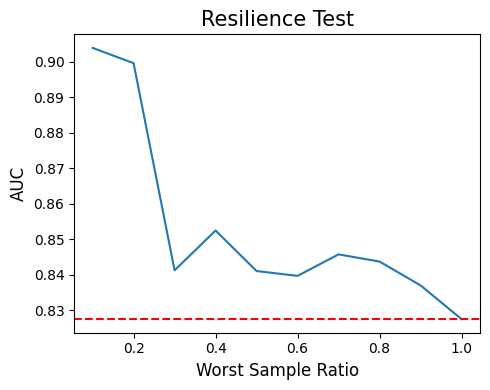

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_perf", resilience_method="outer-sample",
                   metric="AUC", figsize=(5, 4))

Resilience Distance¶

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

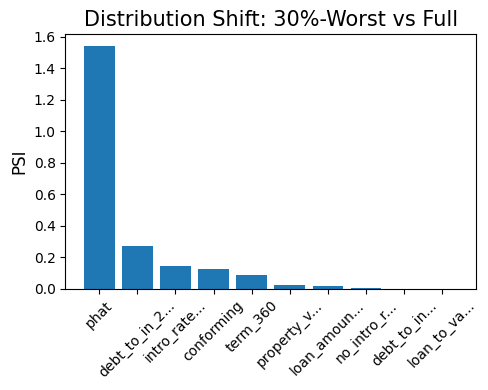

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_distance", resilience_method="worst-sample",
                   distance_metric="PSI", alpha=0.3, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

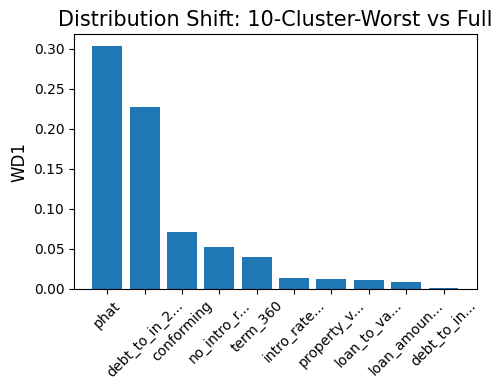

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_distance", resilience_method="worst-cluster",
                   distance_metric="WD1", n_clusters=10, figsize=(5, 4))

Marginal histogram plot for full sample and worst sample

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

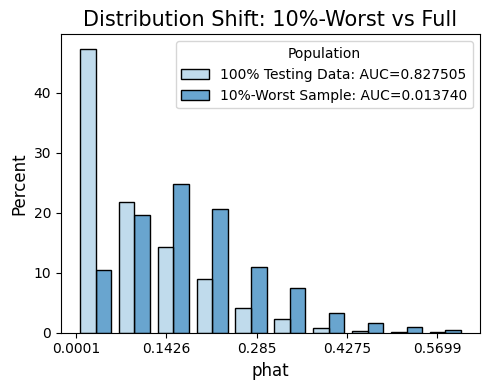

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_shift_histogram", resilience_method="worst-sample",
                   target_feature="phat", original_scale=True, figsize=(5, 4))

Marginal density plot for full sample and worst sample

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

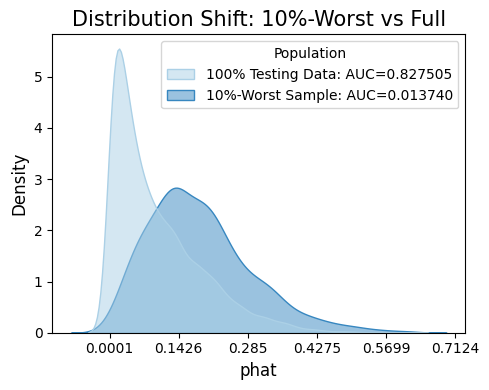

In [ ]:
exp.model_diagnose(model="EBM", show="resilience_shift_density", resilience_method="worst-sample",
                   target_feature="phat", original_scale=True, figsize=(5, 4))

#### End global timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))